In [1]:
%matplotlib inline

import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

import QSTK.qstkutil.qsdateutil as du
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkutil.DataAccess as da

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database',)).History will not be written to the database.


In [2]:
def gen_portfolio_allocations(symbols, resolution):
    alloc_values = np.arange(0., 1.+resolution, resolution)
    alloc_combinations = list(itertools.product(alloc_values, repeat=len(symbols)))
    alloc_combinations = pd.DataFrame(alloc_combinations, columns=symbols)
    return alloc_combinations[alloc_combinations.sum(1) == 1]

In [3]:
gen_portfolio_allocations(['a', 'b'], 0.1)

,a,b
10,0.0,1.0
20,0.1,0.9
30,0.2,0.8
40,0.3,0.7
50,0.4,0.6
60,0.5,0.5
70,0.6,0.4
80,0.7,0.3
90,0.8,0.2
100,0.9,0.1


In [4]:
def simulate_portfolio(start_date, end_date, symbols, allocation):
    timeofday = dt.timedelta(hours=16)
    timestamps = du.getNYSEdays(start_date, end_date, timeofday)
    
    dataobject = da.DataAccess('Yahoo')
    keys = ['close']
    data = dataobject.get_data(timestamps, symbols, keys)
    data_frame = dict(zip(keys, data))
    close_prices = data_frame['close'].values
    normalized_close_prices = close_prices / close_prices[0, :]
    
    daily_returns = normalized_close_prices.copy()
    tsu.returnize0(daily_returns)
    
    portfolio_returns = np.sum(daily_returns * allocation, axis=1)
    portfolio_total = np.cumprod(portfolio_returns + 1)
    component_total = np.cumprod(daily_returns + 1, axis=0)
    
    plt.clf()
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(timestamps, component_total, alpha=0.3)
    plt.plot(timestamps, portfolio_total)
    names = symbols
    names.append('Portfolio')
    plt.legend(names)
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')
    fig.autofmt_xdate(rotation=45)
    return (daily_returns, portfolio_total)

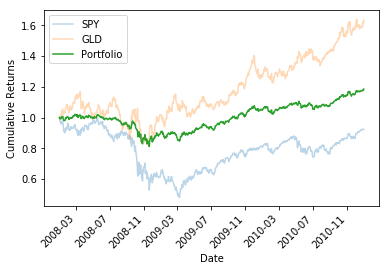

In [22]:
dr, r = simulate_portfolio(dt.datetime(2008, 1, 2), dt.datetime(2011, 1, 1), ['SPY', 'GLD'], [0.3, 0.3])

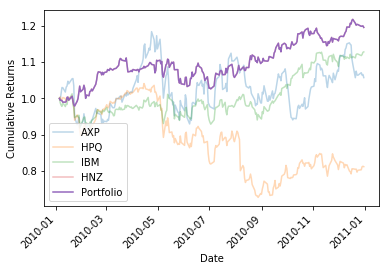

In [26]:
dr1, r1 = simulate_portfolio(dt.datetime(2010, 1, 1), dt.datetime(2010, 12, 31), ['AXP', 'HPQ', 'IBM', 'HNZ'], [0.0, 0.0, 0.0, 1.0])

In [30]:
r1.mean()

1.0991060075031325

In [31]:
r1.std()

0.056175866894891291

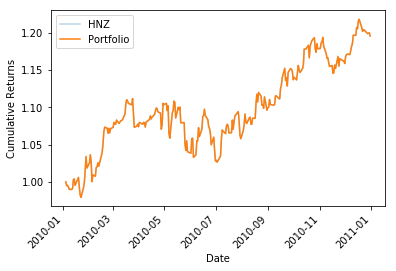

In [25]:
dr2, r2 = simulate_portfolio(dt.datetime(2010, 1, 1), dt.datetime(2010, 12, 31), ['HNZ'], [1.0])